## Ebola infected Macaque Sample Composition Trajectory Identification

In this notebook we deconvolve the ebov macaque blood samples using a matched seq-well reference.

In [1]:
import anndata
import matplotlib.pylab as plt
import torch
from ternadecov.time_deconv import *
from ternadecov.simulator import *
from ternadecov.stats_helpers import *
from ternadecov.dataset import *
from ternadecov.deconvolution_plotter import *
from ternadecov.parametrization import *
from ternadecov.deconvolution_writer import DeconvolutionWriter
from ternadecov.deconvolution_exporter import DeconvolutionExporter

# Configuration

In [2]:
n_iters = 20_000

# Load data

In [3]:
location_fascicularis = '/home/nbarkas/disk2/deconvolution_method/datasets/nhp_fascicularis_atlas/h5ad/'

h5ad_paths = {
    # Ebov Datasets
    "bulk_blood": "ebov_bulk.h5ad",
    "sc_blood": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad",
    "bulk_all": "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/all_ebov_bulk.h5ad",
    
    
    # fascicularis
    "sc_adrenal": f"{location_fascicularis}/Adrenal_gland.h5ad",
    "sc_cerebellum": f"{location_fascicularis}/Cerebellum.h5ad",
    "sc_kidney": f"{location_fascicularis}/Kidney.h5ad",
    "sc_liver": f"{location_fascicularis}/Liver.h5ad",
    "sc_lung": f"{location_fascicularis}/Lung.h5ad",
    "sc_lymph_node": f"{location_fascicularis}/Lymph_node.h5ad",
    "sc_neocortex": f"{location_fascicularis}/Neocortex.h5ad",
    "sc_pbmc": f"{location_fascicularis}/pbmc.h5ad",
    "sc_skin": f"{location_fascicularis}/Skin.h5ad",
    "sc_spleen": f"{location_fascicularis}/Spleen.h5ad",
    "sc_subcutaneous_adipose": f"{location_fascicularis}/Subcutaneous_adipose.h5ad",
    "sc_testis": f"{location_fascicularis}/Testis.h5ad",
    "sc_thyroid": f"{location_fascicularis}/Thyroid_gland.h5ad",
    "sc_uterus": f"{location_fascicularis}/Uterus.h5ad",
    "sc_vagina": f"{location_fascicularis}/Vagina.h5ad",
}

In [4]:
with open(h5ad_paths['bulk_all'], 'rb') as fh:
    all_bulk_anndata = anndata.read_h5ad(fh)

In [5]:
with open(h5ad_paths['sc_skin'], 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [6]:
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['dpi_time'] >= 0,]
all_bulk_anndata = all_bulk_anndata[all_bulk_anndata.obs['full.tissue'].isin(['Skin','Skin:Non-Rash','Skin:Rash'])]

In [7]:
all_bulk_anndata.var.gene = all_bulk_anndata.var.gene.astype(str)
all_bulk_anndata.var = all_bulk_anndata.var.set_index('gene')

Trying to set attribute `.var` of view, copying.


In [8]:
datatype_param = DeconvolutionDatatypeParametrization()

In [9]:
ebov_dataset = DeconvolutionDataset(
    types=datatype_param,
    parametrization = DeconvolutionDatasetParametrization(
        sc_anndata = sc_anndata,
        sc_celltype_col = "Abbreviation",
        bulk_anndata = all_bulk_anndata,
        bulk_time_col = "dpi_time",
        feature_selection_method = 'overdispersed_bulk_and_high_sc'
    )
)

/home/nbarkas/disk1/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.13916e-10): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


log_sc_cutoff: 2
3438 genes selected


# Run Deconvolution

In [10]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolutionModel(
    dataset=ebov_dataset,
    trajectory_model_type='gp',
    hyperparameters=TimeRegularizedDeconvolutionModelParametrization(),
    trajectory_hyperparameters=TimeRegularizedDeconvolutionGPParametrization(),
    types=datatype_param
)

In [11]:
pseudo_time_reg_deconv.fit_model(n_iters=n_iters, verbose=True, log_frequency=1000, clear_param_store=False)

[step: 0, time: 1 s ] loss: 14496083.70
[step: 1000, time: 56 s ] loss: 4892656.55
[step: 2000, time: 117 s ] loss: 1951693.29
[step: 3000, time: 181 s ] loss: 1016984.20
[step: 4000, time: 246 s ] loss: 702768.43
[step: 5000, time: 307 s ] loss: 572888.46
[step: 6000, time: 367 s ] loss: 513236.92
[step: 7000, time: 423 s ] loss: 482771.39
[step: 8000, time: 481 s ] loss: 466450.31
[step: 9000, time: 542 s ] loss: 457669.05
[step: 10000, time: 599 s ] loss: 452577.04
[step: 11000, time: 650 s ] loss: 449604.24
[step: 12000, time: 696 s ] loss: 447732.88
[step: 13000, time: 742 s ] loss: 446565.96
[step: 14000, time: 785 s ] loss: 445648.28
[step: 15000, time: 831 s ] loss: 445004.73
[step: 16000, time: 875 s ] loss: 444493.39
[step: 17000, time: 917 s ] loss: 444161.73
[step: 18000, time: 967 s ] loss: 443916.13
[step: 19000, time: 1003 s ] loss: 443799.28


# Examine Outputs

IndexError: list index out of range

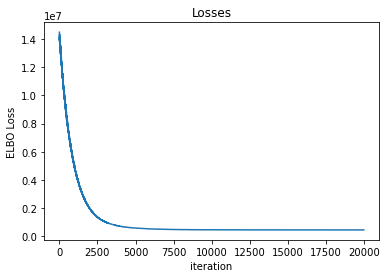

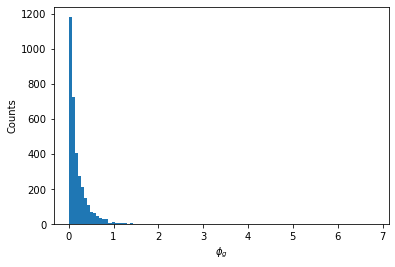

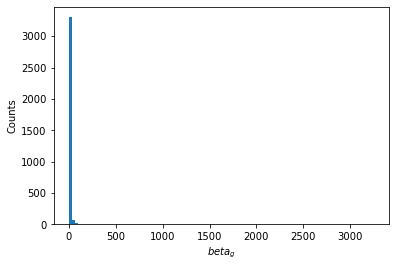

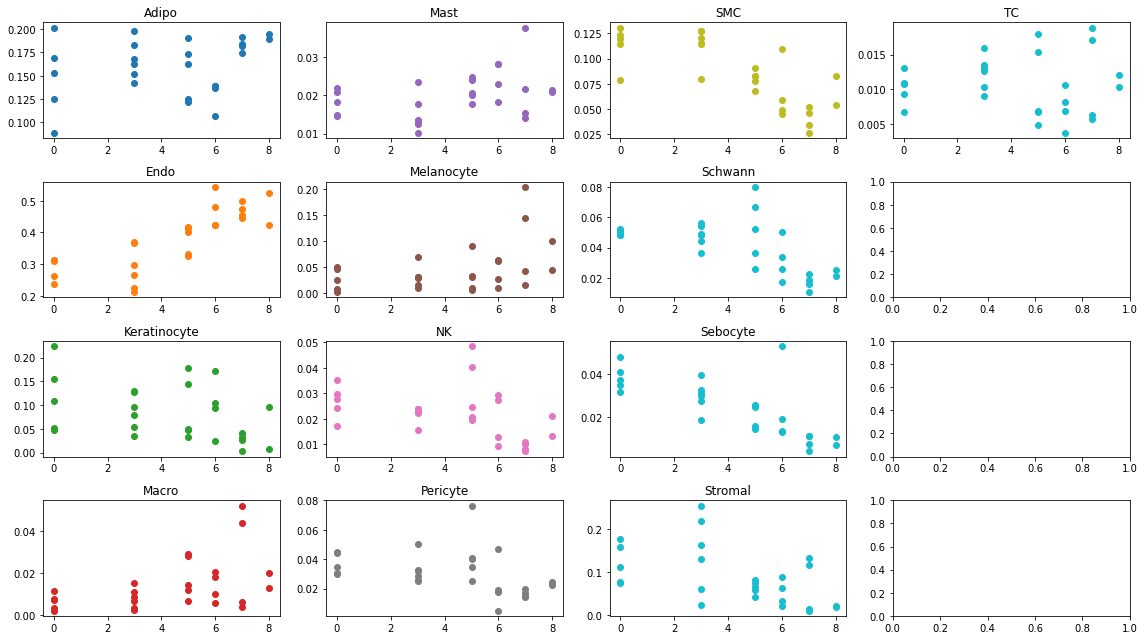

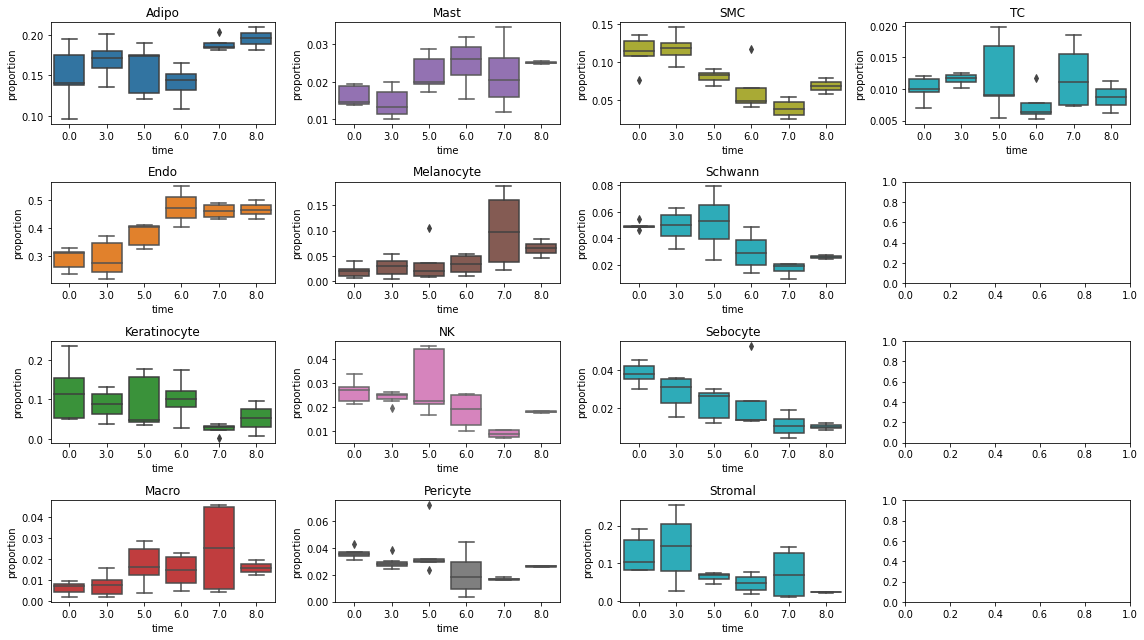

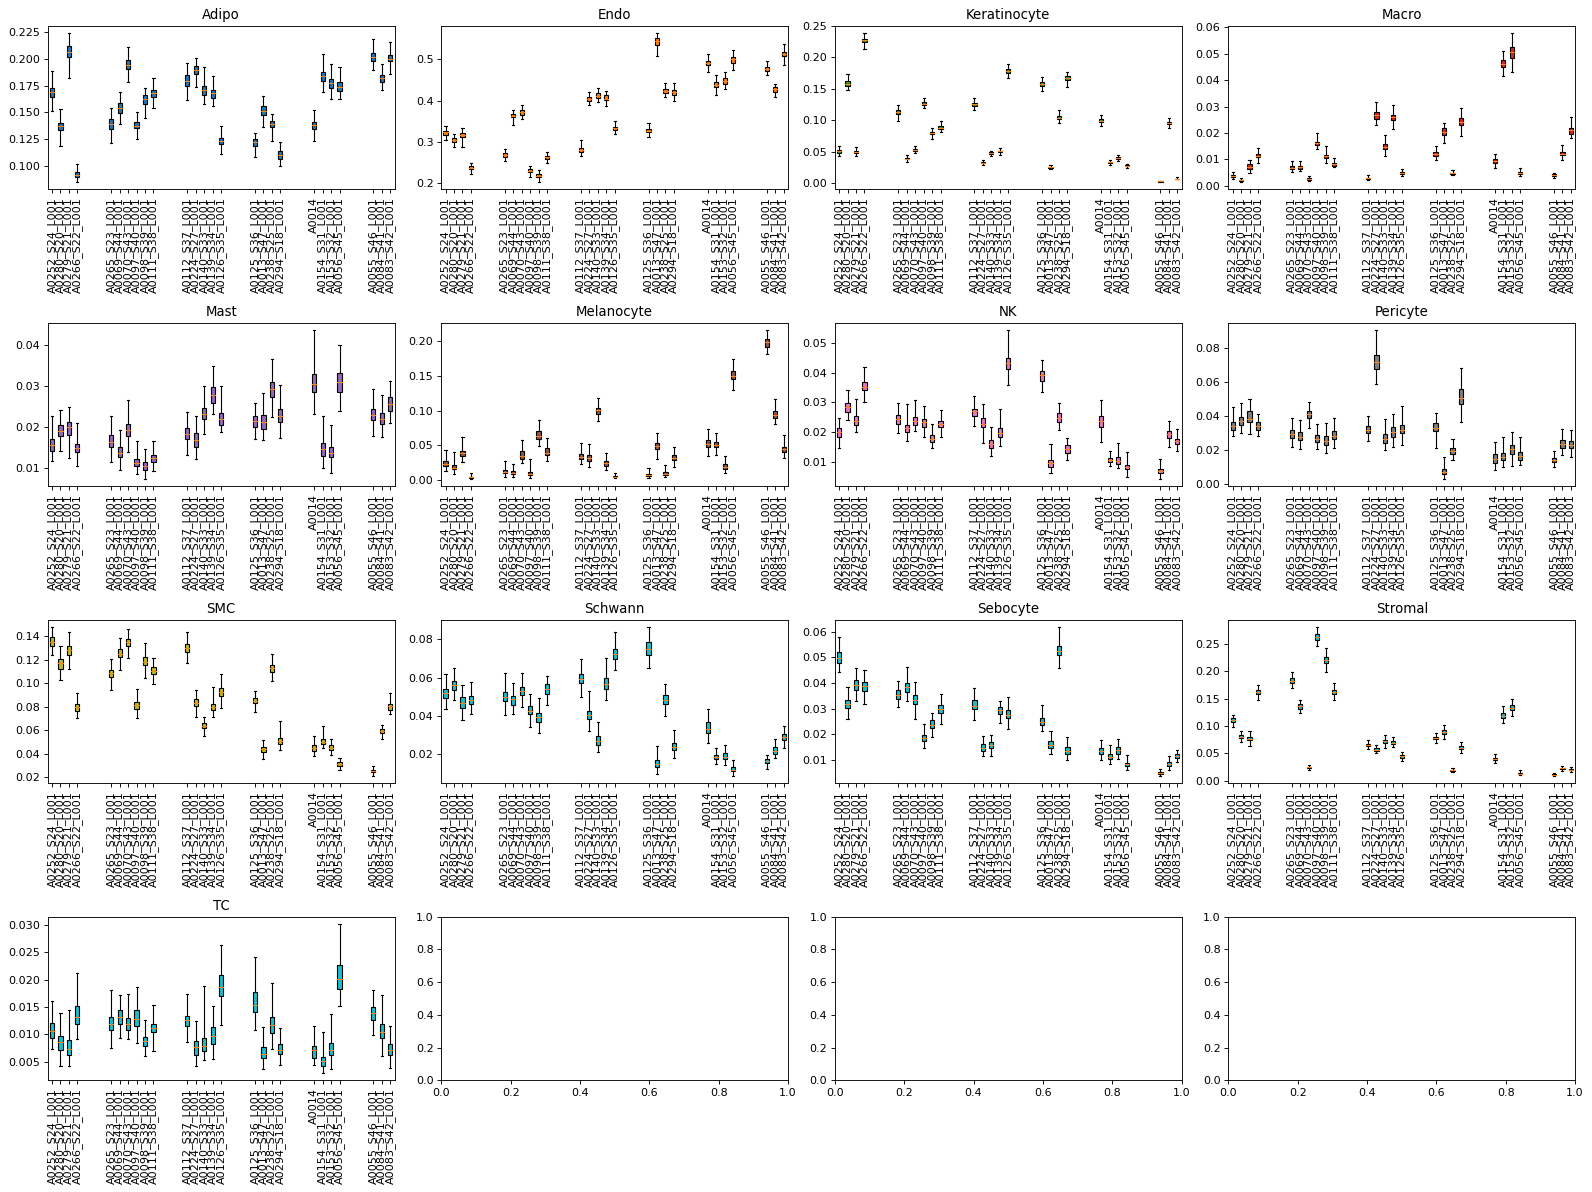

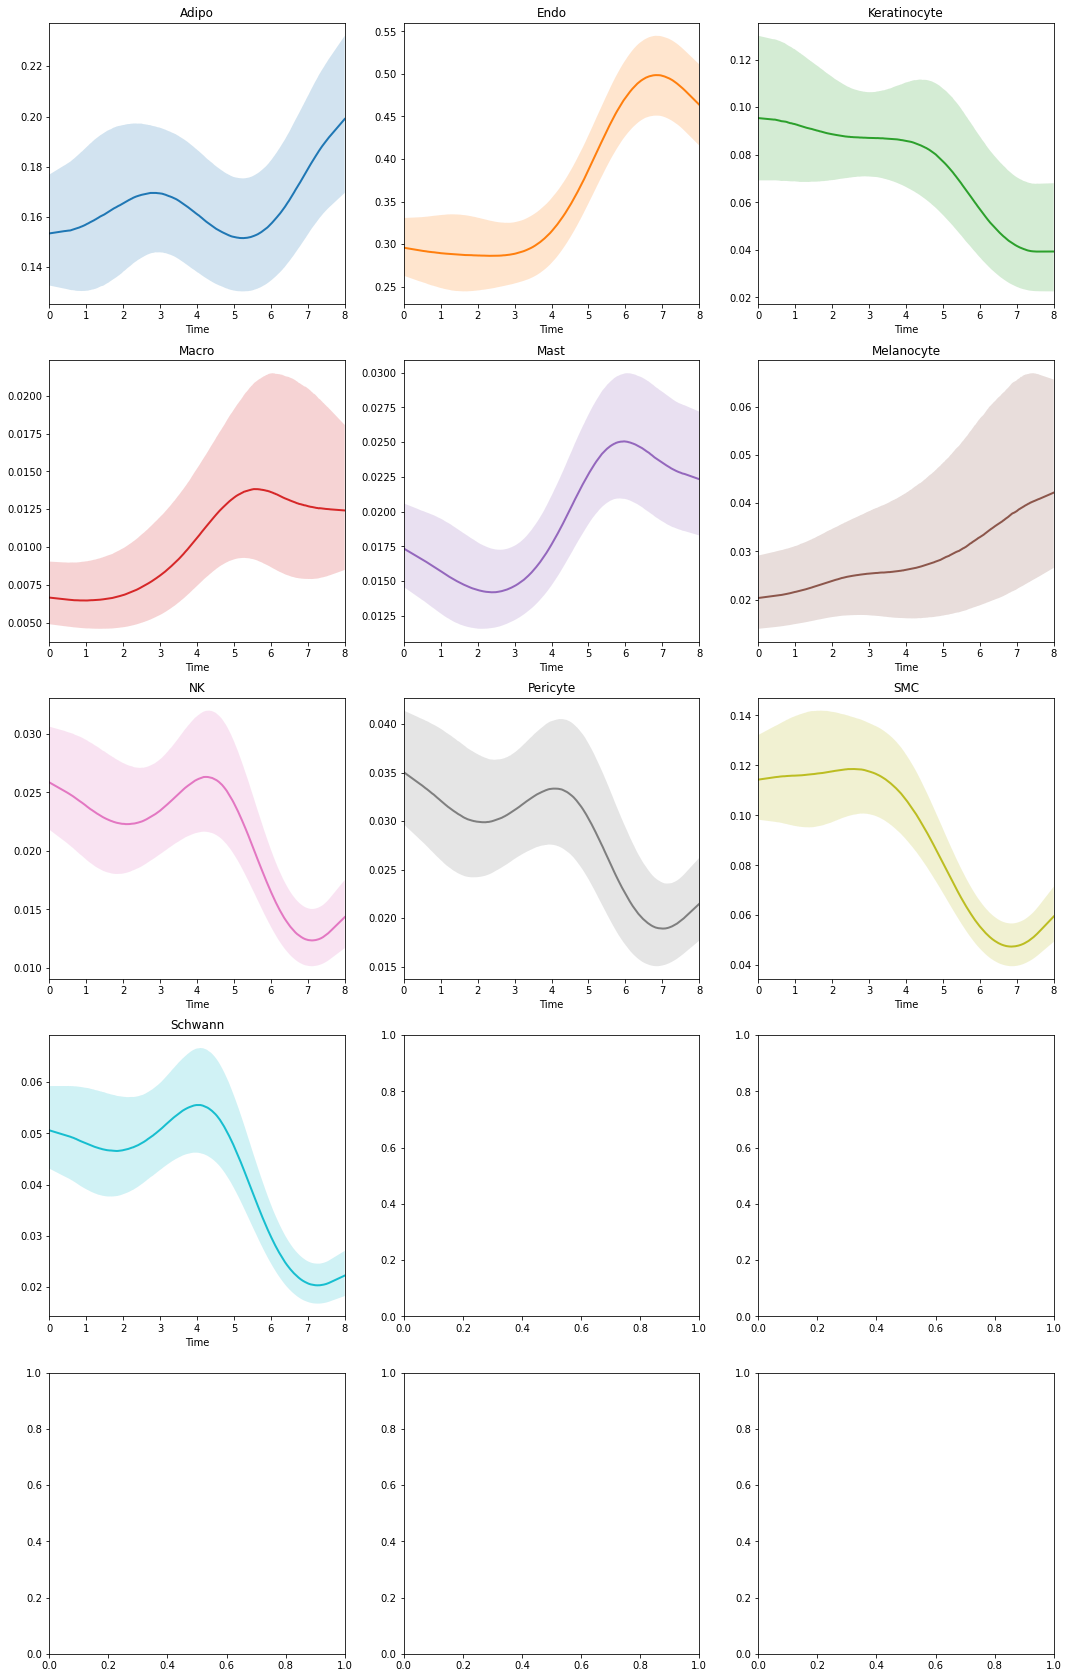

In [12]:
exporter = DeconvolutionExporter(pseudo_time_reg_deconv, prefix = 'skin_')
exporter.export_results('output/skin/')